# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [ ]:
!pip install numpy scikit-learn pandas nltk gensim xgboost transformers


In [ ]:
import pandas as pd
import nltk
import re
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
import gensim
import torch

# we are loading the testing data set

tst_sample = pd.read_csv('stsa-test.txt', sep='delimiter=', header=None, names=['reviews'], engine='python')

tst_sample[['sentiment', 'reviews']] = tst_sample['reviews'].str.split(" ", n=1, expand=True)


# we are loading the training data set

trn_sample = pd.read_csv('stsa-train.txt', sep='delimiter=', header=None, names=['reviews'], engine='python')

trn_sample[['sentiment', 'reviews']] = trn_sample['reviews'].str.split(" ", n=1, expand=True)



# we are downloading the stopwords wordnets
nltk.download('stopwords')
nltk.download('wordnet')
stopword = stopwords.words('english')
wl = WordNetLemmatizer()
# we are cleaning the data
def clean(review):
    review = "".join([word.lower() for word in review if word not in string.punctuation])
    review = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", review)
    tokens = re.split('\W+', review)
    review = [wl.lemmatize(word) for word in tokens if word not in stopword]
    return ' '.join(review)

trn_sample['clean_reviews'] = trn_sample['reviews'].apply(clean)
tst_sample['clean_reviews'] = tst_sample['reviews'].apply(clean)

# we are converting the sentiments into numerical form

label_encoder = LabelEncoder()

trn_sample['sentiment'] = label_encoder.fit_transform(trn_sample['sentiment'])

tst_sample['sentiment'] = label_encoder.transform(tst_sample['sentiment'])

# we are doning TF-IDF Vectorization
t_fidf_vect = TfidfVectorizer()

Xtfidf = t_fidf_vect.fit_transform(trn_sample['clean_reviews'])

Xtfidf_df = pd.DataFrame(Xtfidf.toarray(), columns=t_fidf_vect.get_feature_names_out())

Xtsttfidf = t_fidf_vect.transform(tst_sample['clean_reviews'])

# we are training the model

def evaluate_model(model, X_train, y_train, X_test, y_test, cv=10):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # we are printing the accuracy
    print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, y_pred) * 100))
    print(classification_report(y_test, y_pred))


    srs = cross_val_score(model, X_test, y_test, cv=cv)
    # we ar eprinting the cross validation mean score
    print("Cross-Validation Mean Score: {:.2f}%".format(srs.mean() * 100))


# we are usisng multinomial naive bayes
mltnb = MultinomialNB()

evaluate_model(mltnb, Xtfidf_df, trn_sample['sentiment'], Xtsttfidf, tst_sample['sentiment'])

# we are using linear support-vector-machine
svm = LinearSVC()

evaluate_model(svm, Xtfidf_df, trn_sample['sentiment'], Xtsttfidf, tst_sample['sentiment'])

# we are using k_nearest neighbors
k_ner = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

evaluate_model(k_ner, Xtfidf_df, trn_sample['sentiment'], Xtsttfidf, tst_sample['sentiment'])


# we are using decisiontree

destre = DecisionTreeClassifier()

evaluate_model(destre, Xtfidf_df, trn_sample['sentiment'], Xtsttfidf, tst_sample['sentiment'])

# we are using random Forest
rndf = RandomForestClassifier()

evaluate_model(rndf, Xtfidf_df, trn_sample['sentiment'], Xtsttfidf, tst_sample['sentiment'])

# we are using xgboost
xbt = XGBClassifier()

evaluate_model(xbt, Xtfidf_df, trn_sample['sentiment'], Xtsttfidf, tst_sample['sentiment'])


# we are using word2Vec and training the model

tokenized_reviews = [review.split() for review in trn_sample['clean_reviews']]

word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

def average_word_vectors(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in words:
        if word in model.wv.key_to_index:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

# we are vectorizing train and test datasample using Word2Vec
num_features = 100
trn_sample['word2vec_features'] = trn_sample['clean_reviews'].apply(
    lambda x: average_word_vectors(x, word2vec_model, num_features)
)
tst_sample['word2vec_features'] = tst_sample['clean_reviews'].apply(
    lambda x: average_word_vectors(x, word2vec_model, num_features)
)


from sklearn.svm import SVC

# we are doing the model training and evaluation with Word2Vec using SVM
svm_word2vec = SVC()
evaluate_model(svm_word2vec, np.vstack(trn_sample['word2vec_features']), trn_sample['sentiment'],
               np.vstack(tst_sample['word2vec_features']), tst_sample['sentiment'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


Accuracy: 80.12%
              precision    recall  f1-score   support

           0       0.86      0.72      0.78       912
           1       0.76      0.88      0.82       909

    accuracy                           0.80      1821
   macro avg       0.81      0.80      0.80      1821
weighted avg       0.81      0.80      0.80      1821

Cross-Validation Mean Score: 72.43%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


Accuracy: 79.63%
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       912
           1       0.78      0.83      0.80       909

    accuracy                           0.80      1821
   macro avg       0.80      0.80      0.80      1821
weighted avg       0.80      0.80      0.80      1821

Cross-Validation Mean Score: 70.84%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Accuracy: 49.75%
              precision    recall  f1-score   support

           0       0.50      0.71      0.58       912
           1       0.49      0.29      0.37       909

    accuracy                           0.50      1821
   macro avg       0.50      0.50      0.47      1821
weighted avg       0.50      0.50      0.47      1821

Cross-Validation Mean Score: 52.61%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Accuracy: 66.23%
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       912
           1       0.67      0.63      0.65       909

    accuracy                           0.66      1821
   macro avg       0.66      0.66      0.66      1821
weighted avg       0.66      0.66      0.66      1821

Cross-Validation Mean Score: 62.55%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy: 74.63%
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       912
           1       0.75      0.74      0.74       909

    accuracy                           0.75      1821
   macro avg       0.75      0.75      0.75      1821
weighted avg       0.75      0.75      0.75      1821

Cross-Validation Mean Score: 65.13%
Accuracy: 50.08%
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       912
           1       0.00      0.00      0.00       909

    accuracy                           0.50      1821
   macro avg       0.25      0.50      0.33      1821
weighted avg       0.25      0.50      0.33      1821



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross-Validation Mean Score: 65.19%
Accuracy: 51.62%
              precision    recall  f1-score   support

           0       0.62      0.09      0.16       912
           1       0.51      0.94      0.66       909

    accuracy                           0.52      1821
   macro avg       0.56      0.52      0.41      1821
weighted avg       0.56      0.52      0.41      1821

Cross-Validation Mean Score: 52.67%


In [ ]:
!pip install transformers
!pip install torch


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch

# we are loading pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# we are loading the pre-trained BERT model with uncased vocabulary
bert_model = BertModel.from_pretrained('bert-base-uncased')

# the function for generating the embeddings for the text
def generate_bert_embeddings(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        opt = bert_model(**tokens)
    embeddings = opt.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# we are applying generate_bert_embeddings function to  clean reviews
trn_sample['bert_embeddings'] = trn_sample['clean_reviews'].apply(generate_bert_embeddings)
tst_sample['bert_embeddings'] = tst_sample['clean_reviews'].apply(generate_bert_embeddings)

#we are printing the bERT embeddings for the 1st training sample
print("bERT embeddings for the 1st Training Sample:")
print(trn_sample['bert_embeddings'].iloc[0])

# the embedding which we got her will be used for feature requirements or also for model training

# the embidding we get here will be in the form of numpy arrays.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

bERT embeddings for the 1st Training Sample:
[-1.40036151e-01  3.55117805e-02  2.13999808e-01 -6.65000454e-02
  4.71104950e-01 -7.52719194e-02  3.07842910e-01 -8.16104710e-02
 -2.64929682e-01 -2.83197403e-01  2.91915447e-01 -2.10371628e-01
  2.46222243e-01  5.01004577e-01 -1.93359241e-01  3.99349689e-01
 -6.71940967e-02 -1.82531834e-01 -3.81843261e-02  1.44969895e-01
 -5.36905006e-02 -1.42853081e-01 -5.47963567e-02  2.33093828e-01
  1.04806267e-01 -2.09600419e-01 -9.51560438e-02  1.38024315e-01
 -3.71773452e-01  1.53841898e-01 -5.12005668e-03 -1.99296698e-01
 -2.53173053e-01  4.96442802e-02  4.81599346e-02 -3.59166443e-01
 -2.68733650e-01 -1.81531578e-01 -1.72955985e-03  3.47850956e-02
 -5.44842780e-01 -2.31957257e-01  5.10981500e-01 -2.59197634e-02
 -4.52730030e-01 -2.95796841e-01 -1.97576731e-01 -1.37414664e-01
  5.75045832e-02 -2.69117475e-01  1.16129950e-01  2.28477001e-01
 -1.46899551e-01 -1.63072929e-01 -8.16041455e-02  6.55950546e-01
 -1.55862525e-01 -5.08638740e-01 -8.56411085e

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [ ]:
# we are importing the required packages
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# we are load the sample
data = pd.read_csv('Amazon_Unlocked_Mobile.csv')  # Replace with your actual dataset path

# we are doing tF-IDF Vectorization
vect = TfidfVectorizer(stop_words='english')
tfidf = vect.fit_transform(data['Reviews'])

# we are doing K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(tfidf)

# wea re doing DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
data['DBSCAN_Cluster'] = dbscan.fit_predict(tfidf)

# we are doing Hierarchical clustering
agc = AgglomerativeClustering(n_clusters=3)
data['Hierarchical_Cluster'] = agc.fit_predict(tfidf.toarray())

# we are doing Word2Vec clustering


# Tokenize the reviews
trev = []
for review in data['Reviews']:
    tt = review.split()
    trev.append(tt)


w2_model = Word2Vec(sentences=trev, vector_size=100, window=5, min_count=1, workers=4)
X_word2vec = np.array([np.mean([w2_model.wv[word] for word in words], axis=0) for words in trev])

# the Standardize Word2Vec vectors for K-means
sc = StandardScaler()
xwscled = sc.fit_transform(X_word2vec)

# we are applying  K-means clustering on Word2Vec vectors
kwvec = KMeans(n_clusters=3, random_state=42)
data['Word2Vec_Cluster'] = kwvec.fit_predict(xwscled)

# we are doing bert embeddings
tkzr = BertTokenizer.from_pretrained('bert-base-uncased')
mdl = BertModel.from_pretrained('bert-base-uncased')

def bert_embeddings(reviews):
    tk = tkzr(reviews, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = mdl(**tk)
    embeddings = outputs['last_hidden_state'][:, 0, :].numpy()
    return embeddings

xbert = np.vstack(data['Reviews'].apply(bert_embeddings))

# we are applying K-means clustering on BERT embeddings
kmb = KMeans(n_clusters=3, random_state=42)
data['BERT_Cluster'] = kmeans_bert.fit_predict(xbert)

# we are visualizing the clusters using PCA
def plot_clusters(embeddings, cluster_labels, title):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)

    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
    plt.title(title)
    plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


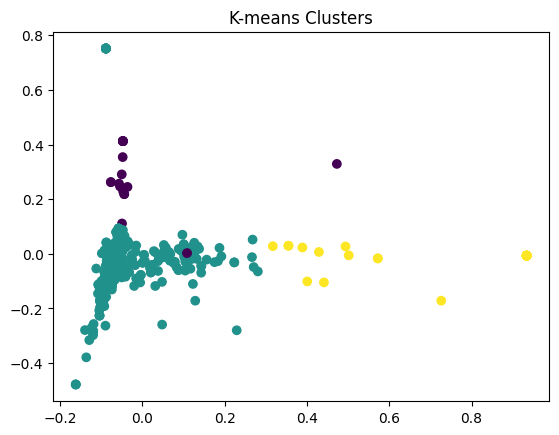

K-means:
Number of clusters: 3
Silhouette Score: 0.03181172846812503


In [ ]:
# we are ploting the clusters for K-means
plot_clusters(Xtfidf.toarray(), data['KMeans_Cluster'], 'K-means Clusters')

# we are printing the K-means results
print("K-means:")
print("Number of clusters:", len(np.unique(data['KMeans_Cluster'])))
print("Silhouette Score:", silhouette_score(Xtfidf, data['KMeans_Cluster']))



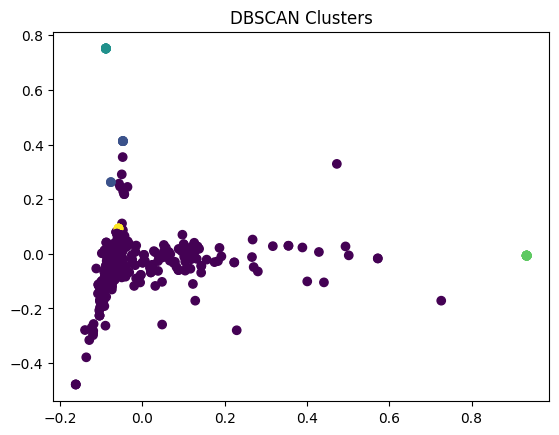


DBSCAN:
Number of clusters: 5
Number of noise points: 463


In [ ]:
# we are ploting clusters for DBSCAN
plot_clusters(Xtfidf.toarray(), data['DBSCAN_Cluster'], 'DBSCAN Clusters')

# we are printing DBSCAN results
print("\nDBSCAN:")
print("Number of clusters:", len(np.unique(data['DBSCAN_Cluster'])))
print("Number of noise points:", np.sum(data['DBSCAN_Cluster'] == -1))



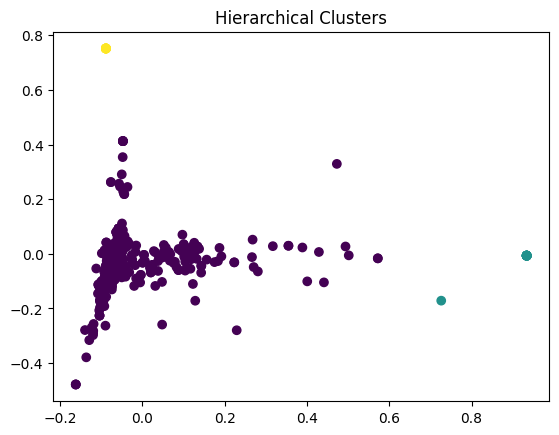


Hierarchical Clustering:
Number of clusters: 3
Silhouette Score: 0.04102275374294593


In [ ]:
# we are ploting clusters for Hierarchical clustering
plot_clusters(Xtfidf.toarray(), data['Hierarchical_Cluster'], 'Hierarchical Clusters')

# we are printing Hierarchical clustering results
print("\nHierarchical Clustering:")
print("Number of clusters:", len(np.unique(data['Hierarchical_Cluster'])))
print("Silhouette Score:", silhouette_score(Xtfidf, data['Hierarchical_Cluster']))



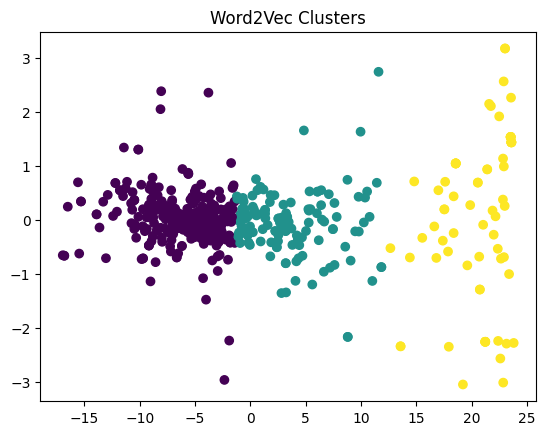


Word2Vec:
Number of clusters: 3
Silhouette Score: 0.5730229


In [ ]:
# we are ploting clusters for Word2Vec
plot_clusters(xwscled, data['Word2Vec_Cluster'], 'Word2Vec Clusters')

# we are printing Word2Vec results
print("\nWord2Vec:")
print("Number of clusters:", len(np.unique(data['Word2Vec_Cluster'])))
print("Silhouette Score:", silhouette_score(xwscled, data['Word2Vec_Cluster']))



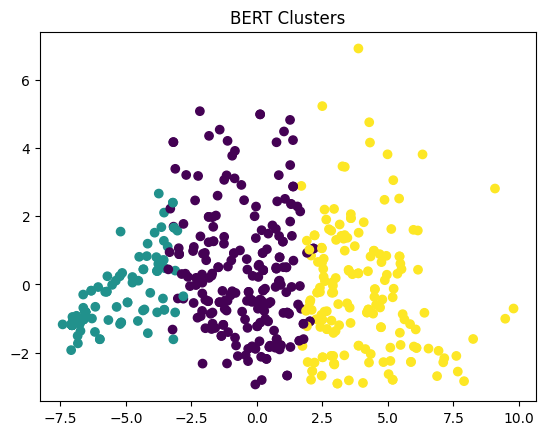


BERT:
Number of clusters: 3
Silhouette Score: 0.11644047


In [ ]:
# we are ploting clusters for BERT
plot_clusters(xbert, data['BERT_Cluster'], 'BERT Clusters')

# we are printing BERT results
print("\nBERT:")
print("Number of clusters:", len(np.unique(data['BERT_Cluster'])))
print("Silhouette Score:", silhouette_score(xbert, data['BERT_Cluster']))

**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

Numerous text clustering includes K-means, DBSCAN, and hierarchical clustering, these are available in unsupervised machine learning. we divide the data into k clusters, K-means used for the Euclidean distance between the cluster centroids and data points. In contrast, DBSCAN uses closeness for identifying the dense regions in the feature space that can be grouped together. By repeatedly combining smaller clusters into bigger clusters, hierarchical clustering creates a hierarchy within the clusters.

.

 text clustering problems in natural language processing can be handled by word embedding models such as Word2Vec and BERT. Text clustering is one of the NLP tasks that can be effectively tailored for using BERT, a transformer-based approach. In the meantime, Word2Vec, a model based on neural networks, predicts word contexts in a corpus to learn word embeddings.



we do clustering on the data using K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT embeddings.
we get gifferent number of clusters for each methods.K-means, DBSCAN, and Hierarchical clustering do
distinct clustering with where k means have Silhouette Score: 0.03181172846812503,DBSCAN has Number of clusters: 5 and Hierarchical Clustering has 3 clusters with Silhouette Score: 0.04102275374294593
Word2Vec has 3 clusters with  Silhouette Score: 0.5730229 and BERT has 3 clusters with
Silhouette Score: 0.11644047 among all we got highest Silhouette Score of 0.57 for Word2Vec and lower for k_means with Silhouette Score of 0.031
based on the requirements for the data we use which ever method is good enough




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:
i find the inclass exercise added good knowledge to me but the time provided for inclass exercise completion i hope it was not sufficient.
i find it a bit difficult to complete it in 1 day.

as this is the final exercise of the class i have gained a lot of knowledge with this course.
assignments contributed the most for my knowledge.

thanks for asking the feedback for every assignments.




'''

'\nPlease write you answer here:\ni find the inclass exercise added good knowledge to me but the time provided for inclass exercise completion i hope it was not sufficient.\ni find it a bit difficult to complete it in 1 day.\n\nas this is the final exercise of the class i have gained a lot of knowledge with this course.\nassignments contributed the most for my knowledge.\n\nthanks for asking the feedback for every assignments.\n\n\n\n\n'